In [1]:
import qaoa
import qucompsys as qucs
import graphs as gr
import qutip as qu
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
import networkx as nx
from   networkx.generators.random_graphs import erdos_renyi_graph
import configparser
import scipy
import itertools
from collections import Counter

%matplotlib inline
%config InlineBackened.figure_format = 'svg'

# Apply QAOA for MaxCut problem:

here we're going to implement the general QAOA approach for a specific CSP problem, using the SGD method for parameters optimization,the steps are:

* define the problem and the specific object is referred to (which gives also $C$)
* parameter optimization:<br>
    * choose QAOA-level = p and pick p-pairs parameters $(\gamma_1,...,\gamma_p,\beta_1,...,\beta_p)_0$<br>
    * generate initial state $|s\rangle$ (usually is chosen to be easy to be prepeared) (which gives also $B$)<br>
    * evolve $|s\rangle$ in $|\vec{\gamma},\vec{\beta}\rangle$ through 2p evolutions<br>
    * evaluate $F_p$ (or only certain terms of it) through N-times computational basis measurement on $|\vec{\gamma},\vec{\beta}\rangle$, obtained as the "classical" meanvalue of the N-outcomes
    * update the parameters<br>
    different methods may be implemented for parameters update, here we're going to see:
        * grid search <br>
        * $0^{th}$-order SGD method (_finite differencies_) (perform it M-times/until $- \nabla F_p(\vec{\gamma},\vec{\beta}) \approx 0$/...)<br>
        * $1^{st}$-order SGD method (_doubly SGD_) (perform it M-times/until $- \nabla F_p(\vec{\gamma},\vec{\beta}) \approx 0$/...)<br>        
* $(\vec{\gamma},\vec{\beta})$ which optimize $F_p$ will be obtained after these iterations (and the solutions to the problem could be seen from frequencies of strings obtained in the computational basis measurement for these angles)

A.1 special case: 1-level QAOA for MaxCut

* get information of the graph
* parameter optimization:
    * evaluate analitical exspression of $F_1(\gamma, \beta)$ from graph informations
    * maximization may be computed through:
        * grid search
        * scipy built-in function
        * other methods ...
* optimal $(\gamma, \beta)$ will the ones that maximize $F_1$

##  0 Define the graph

**method_1**: define manually graphs

In [2]:
#house
n_nodes = 5
nodes = np.arange(0, n_nodes, 1)
edges = [(0,1),(1,2),(1,4),(0,4),(2,3),(3,4)]

In [3]:
n_qubits = n_nodes
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
edges = list(graph.edges)

**method_2**: take information from files

**method_3**: generate random graph

### 0.1 plot the graph

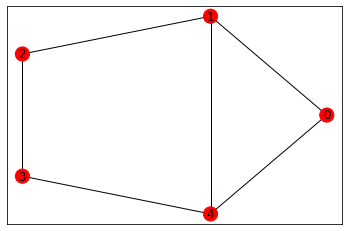

In [4]:
colors = ['r' for node in graph.nodes()]
pos = nx.circular_layout(graph)
graph_drawing = nx.draw_networkx(graph, node_color=colors, node_size=200, alpha=1, pos=pos, with_labels=True)
plt.show()

### 0.2 Find maximum cuts by checking all possible configurations

Define objective function
$$C(z) = \sum_{\alpha = 1}^{m}C_{\alpha}(z),$$
with $C_{\alpha} = \frac{1}{2}(z_u - z_v)$, where $\alpha = \, <u,v> \, \in \, \{<u,v>\} = E$, set of all edges 

Obtain a list of all possible configurations (as bit strings)

In [5]:
def find_maximum_cuts (n_qubits, edges):
    configurations = []
    for i in range(2**(n_qubits-1)):
        configurations.append(bin(i)[2:].zfill(n_qubits))
    dict_cuts = {}
    for config in configurations:
        dict_cuts[config] = qaoa.evaluate_cost_fun(config, edges)
    max_cost_fun = max(list(dict_cuts.values()))
    maximum_cuts = []
    for key in dict_cuts.keys():
        if dict_cuts[key] == max_cost_fun:
            maximum_cuts.append(key)
    return maximum_cuts

In [6]:
find_maximum_cuts(n_qubits, edges)

['00101', '01010']

In [7]:
a_maximum_cut = find_maximum_cuts(n_qubits, edges)[0]
max_cost_fun = qaoa.evaluate_cost_fun (a_maximum_cut, edges)
max_cost_fun

5

In [8]:
configurations = list(itertools.product([0,1], repeat = n_qubits))
dict_cuts = {}
for i in range(2**(n_qubits-1)):
    dict_cuts[configurations[i]] = qaoa.evaluate_cost_fun(configurations[i], edges)

In [9]:
#print frquencies of cuts 
print(np.unique(list(dict_cuts.values()), return_counts = True))

(array([0, 2, 3, 4, 5]), array([1, 4, 6, 3, 2], dtype=int64))


{(0, 0, 1, 0, 1): 5, (0, 1, 0, 1, 0): 5}


(array([1., 0., 0., 0., 4., 0., 6., 0., 3., 2.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

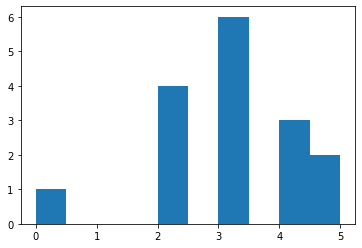

In [10]:
dict_max_cuts = dict((config, max_cut) for config, max_cut in dict_cuts.items() if max_cut == np.max(list(dict_cuts.values())))
print(dict_max_cuts)
plt.hist(dict_cuts.values())

In [11]:
list(dict_max_cuts.keys())

[(0, 0, 1, 0, 1), (0, 1, 0, 1, 0)]

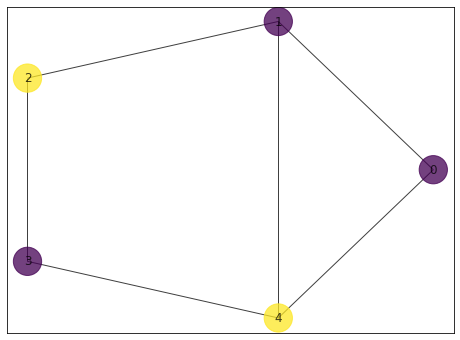

In [12]:
#print one max_cut
fig = plt.figure(figsize=(8,6))
colors = list(dict_max_cuts.keys())[0]
pos = nx.circular_layout(graph)
nx.draw_networkx(graph, node_color=colors, node_size=800, alpha = 0.75, pos=pos)

## Extra 1: Parameters optimization for special case of p = 1

for p = 1 QAOA level, for MaxCut, there's a therorem that gives an analitical expression of $F_p$:

$$F_1(\gamma,\beta) = \langle C \rangle = \sum_{<u,v>} C_{<u,v>} = \sum_{<u,v>} 
\frac{1}{2} + \frac{1}{4} (sin4\beta sin2\gamma)(cos^{d_u}\gamma + cos^{d_v}\gamma) - \frac{1}{4}(sin^2\beta cos^{d_u + d_v - 2\lambda_{uv}}\gamma)(1-cos^{\lambda_{uv}}2\gamma)$$

so, for each edge $<u,v>$, we have to get:
* $d_u$: degree of vertex $u$ -1
* $d_v$: degree of vertex $v$ -1
* $\lambda_{uv}$: number common neighbours of vertices $u$ and $v$

### 3.1 define functions to get $F_1$

define function to get $d_u + 1$

define function to get $\lambda_{uv}$

find $F_1$ maxima

define function which evaluates $F_1(\gamma, \beta)$

find $(\gamma, \beta)$ which maximize $F_1$

**method 1**: Grid search for the minimizing paramenters

define grid of possible values of $(\gamma, \beta)$, with $\gamma \in [0,\pi]$ and $\beta \in [0,\pi]$ and step size = 0.1

**1) use meshgrid**

In [15]:
step_size = 0.01
a_gamma_mesh         = np.arange(-np.pi/2, np.pi/2, step_size) #see article with QAOA scheme for reference of this interval
a_beta_mesh          = np.arange(-np.pi/4, np.pi/4, step_size)
a_gamma_mesh, a_beta_mesh = np.meshgrid(a_gamma_mesh, a_beta_mesh, indexing='xy')
parameters_mesh = np.array([a_gamma_mesh, a_beta_mesh])

In [16]:
# Grid search for the maximizing variables
grid_F_1_mesh = qaoa.analitic_F_1(parameters_mesh, graph, edges)
result_mesh = np.where(grid_F_1_mesh == np.amax(grid_F_1_mesh))
max_pos_mesh      = list(zip(result_mesh[0],result_mesh[1]))[0]

In [17]:
optimal_gamma_mesh   = max_pos_mesh[1]*step_size
optimal_beta_mesh  = max_pos_mesh[0]*step_size

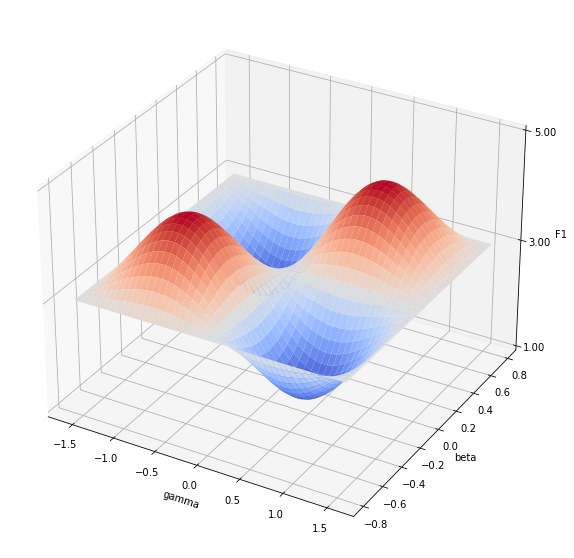


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  F_1 = 4.304
where the max_C is  5
This is attained for gamma = 2.270 and beta = 1.180


In [18]:
# Plot the expetation value grid_f_1
fig = plt.figure(figsize = (10,10))
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(parameters_mesh[0], parameters_mesh[1], grid_F_1_mesh, cmap=cm.coolwarm, linewidth=0, antialiased=True)

a_maximum_cut = find_maximum_cuts(n_qubits, edges)[0]
max_cost_fun = qaoa.evaluate_cost_fun (a_maximum_cut, edges)
ax.set_zlim(1,max_cost_fun)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel('beta')
ax.set_xlabel('gamma')
ax.set_zlabel('F1')

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  F_1 = %.03f' % np.amax(grid_F_1_mesh))
print('where the max_C is ', max_cost_fun)
print('This is attained for gamma = %.03f and beta = %.03f' % (optimal_gamma_mesh, optimal_beta_mesh))

**2) use itertools**

In [19]:
step_size = 0.01
a_gamma_iter         = np.arange(-np.pi/2, np.pi/2, step_size)
a_beta_iter          = np.arange(-np.pi/4, np.pi/4, step_size)
grid_gammas_betas_iter = list(itertools.product(a_gamma_iter, a_beta_iter))
grid_F_1_iter = []
for par_iter in grid_gammas_betas_iter:
    grid_F_1_iter.append(qaoa.analitic_F_1(np.reshape(par_iter, (2,1)), graph, edges))

In [20]:
optimal_gamma_iter  = grid_gammas_betas_iter[grid_F_1_iter.index(max(grid_F_1_iter))][0]
optimal_beta_iter  = grid_gammas_betas_iter[grid_F_1_iter.index(max(grid_F_1_iter))][1]

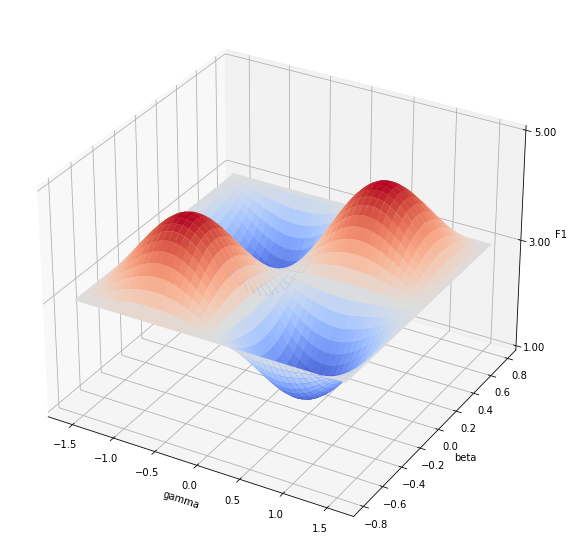


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  F_1 = 4.304
where the max_C is  5
This is attained for gamma = 0.699 and beta = 0.395


In [21]:
# Plot the expetation value grid_f_1
fig = plt.figure(figsize = (10,10))
ax  = fig.gca(projection='3d')


y_axis, x_axis = np.meshgrid(a_beta_iter, a_gamma_iter)
z_axis = np.reshape(np.array(grid_F_1_iter), y_axis.shape)
surf = ax.plot_surface(x_axis, y_axis, z_axis, cmap=cm.coolwarm, linewidth=0, antialiased=True)
surf = ax.plot_surface(x_axis, y_axis, z_axis, cmap=cm.coolwarm, linewidth=0, antialiased=True)

a_maximum_cut = find_maximum_cuts(n_qubits, edges)[0]
max_cost_fun = qaoa.evaluate_cost_fun (a_maximum_cut, edges)
max_cost_fun
ax.set_zlim(1,max_cost_fun)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel('beta')
ax.set_xlabel('gamma')
ax.set_zlabel('F1')

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  F_1 = %.03f' % np.amax(z_axis))
print('where the max_C is ', max_cost_fun)
print('This is attained for gamma = %.03f and beta = %.03f' % (optimal_gamma_iter, optimal_beta_iter))

**method 2**: use scipy built-in function

In [26]:
scipy.optimize.minimize(qaoa.minus_analitic_F_1, [0.0, 0.0], args = (graph, edges), method='Nelder-Mead')

 final_simplex: (array([[0.69573323, 0.39266835],
       [0.69565416, 0.39270949],
       [0.69582684, 0.39271846]]), array([-4.30442848, -4.30442848, -4.30442845]))
           fun: -4.304428482144781
       message: 'Optimization terminated successfully.'
          nfev: 133
           nit: 68
        status: 0
       success: True
             x: array([0.69573323, 0.39266835])

In [28]:
optimal_params_scipy = scipy.optimize.minimize(qaoa.minus_analitic_F_1, [0.0, 0.0], args = (graph, edges), method='Nelder-Mead')['x']
optimal_gamma_scipy = optimal_params_scipy[0]
optimal_beta_scipy = optimal_params_scipy[1]

## 1 Parameters optimization

## 1.1 Choose QAOA level and pick initial parameters

## 1.2 Generate initial state

${\large |s\rangle = \sum_{z \, \in \, \{0,1\}^n}^{}{|z\rangle} = |+\rangle^{\otimes n}}$

## 1.3 Obtain final state

${\large |\vec{\gamma},\vec{\beta}\rangle = U(B,\beta_p)U(C,\gamma_p)...U(B,\beta_1)U(C,\gamma_1)|s\rangle}$

##  1.4 Perform N-computational_basis measurements on $|\vec{\gamma},\vec{\beta}\rangle$ and evaluate $F_p$

the idea is that, for each ($\gamma,\beta$), after each measurement I will obtain as outcome one of the elements of the computational basis: $\{z : z \in \{ 0,1 \}^n\}$

so, after N measurements, I will have each that each possible outcome $z_i$ has been obtained with occurency $w_i$, so $F_p$ will be evaluated as:

$$F_p = \frac{\sum_{i}^{N}{w_iC(z_i)}}{\sum_{i}^{N}{w_i}}$$

## 1.5 Parameter update

### 1.5.1 Grid search method

The idea is that $F_p$ is evaluated for each combination of values in a $2p$-dimensional space

### 1.5.2 SGD methods

at $t$-th parameters choice, with parameters $\vec{\theta}^{(t)} = (\gamma_1,...,\gamma_p,\beta_1,...,\beta_p)_k$, 
the next parameters $\vec{\theta}^{(t+1)} = (\gamma_1,...,\gamma_p,\beta_1,...,\beta_p)^{(t+1)}$ are obtained through:
* evalutating the descent step $\eta^{(t)}$ (here we can start with the stationary case where $\theta^{(t)} = \bar{\eta} = constant$)
* estimate the slope direction $\vec{g}(\vec{\theta}^{(t)}) := - \nabla F(\vec{\theta}^{(t)})$
* $\vec{\theta}^{(t+1)} = \vec{\theta}^{(t)} + \eta^{(t)} \vec{g}(\vec{\theta}^{(t)})$

#### 1.5.2.1 **Evaluate $\eta^{(t)}$**

**method 1**: $\eta = \bar{\eta} = constant$

**method 2**: Adagrad method

**method 3**: Adam method

#### 1.5.2.2 estimate the gradient $\vec{g}(\vec{\theta}^{(t)}) := - \nabla F(\vec{\theta}^{(t)})$

**method 1** $0^{th}$-order SGD method: finite differences

 $ \nabla F_p (\vec{\theta}) = \begin{bmatrix}
\frac{\partial F}{\partial \theta_1}\\
\vdots\\
\frac{\partial F}{\partial \theta_2p}
\end{bmatrix}$,
here each partial derivative $\frac{\partial F}{\partial \theta_i}$ will be evaluated with the _finite differences method_:

**Finite difference method**:

There are 3 main _difference formulas_ for numerically approximating derivatives:<br><br>
* the _forward difference formula_ with step size $h$ is <br>
    $$f'(a) \approx \frac{f(a+h)-f(a)}{h}$$ <br>
* the _backward difference formula_ with step size $h$ is <br>
    $$f'(a) \approx \frac{f(a)-f(a-h)}{h}$$ <br>
* The _central difference formula_ with step size  is the average of the forward and backwards difference formulas <br>
    $$f'(a) \approx \frac{f(a+h)-f(a-h)}{2h}$$

we're going to use the central method:

for a multivariable function $F(\vec{\theta})$, $\large \frac{\partial F}{\partial \theta_i} = \frac{F(\vec{\theta} + h\vec{e}_i) - F(\vec{\theta} - h\vec{e}_i)}{2h}$, with $\vec{e}_i$ $i$-th element of the standard basis    

**method 1: $\eta = const$**

In [33]:
# perform M-steps for expectation value of the cost-function
n_steps = 10
#parameters = np.array(0.5*np.random.random_sample(2*n_levels))
parameters = 0.01*np.random.rand(2*n_levels)
eta = 0.05 #con 0.01 si muove troppo lentamente, però con 0.1 oscilla troppo attorno al massimo
for i in range(n_steps):
    parameters = parameters + eta*qaoa.fin_diff_grad(qaoa.evaluate_F_p, parameters, args=(n_qubits, edges, 100), increment=0.1)
    if (i + 1) % 1 == 0:
            print('in', parameters, "objective after step {:5d}: {: .7f}".format(i + 1, qaoa.analitic_F_1(parameters, graph, edges)))
optimal_parameters = parameters
print('optimal parameters are ', optimal_parameters)

in [-0.00390856  0.01155257] objective after step     1:  2.9994584
in [-0.03390856  0.06405257] objective after step     2:  2.9742482
in [-0.05390856 -0.03594743] objective after step     3:  3.0231128
in [-0.04640856 -0.03344743] objective after step     4:  3.0185348
in [-0.07390856 -0.04344743] objective after step     5:  3.0381484
in [-0.02640856 -0.07594743] objective after step     6:  3.0236843
in [-0.13140856 -0.14594743] objective after step     7:  3.2138744
in [-0.28390856 -0.20844743] objective after step     8:  3.5853840
in [-0.32140856 -0.31094743] objective after step     9:  3.8297270
in [-0.39390856 -0.40094743] objective after step    10:  4.0219534
optimal parameters are  [-0.39390856 -0.40094743]


**method 2: Adam**

![Adam algorithm](./images/AdamAlgorithm.PNG)

In [101]:
#perform it for exp_F_1 (check if this method works properly for p=1 case)
n_steps = 10
#parameters = np.array(0.5*np.random.random_sample(2*n_levels)) #check how choose initial params, for pi*rand is too dispersive
parameters = np.zeros(2*n_levels) # method used in the paper
for j in range(2*n_levels):
    if j%2 == 0: #for H-p parameters
        parameters[j] = j/(2*n_levels) #see SGD paper for reference
    else:
        parameters[j] = 1 - j/(2*n_levels) #see SDG paper
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
m_t = np.zeros(2*n_levels)
v_t = np.zeros(2*n_levels)
t = 0
eta = 0.01 #works also for eta = 0.01, but increases very slowly
previous_g_t = np.zeros(2*n_levels)
for i in range(n_steps):
    g_t = fin_diff_grad(qaoa.evaluate_F_p, parameters, args=(n_qubits, edges, 100), increment=0.1)
    if (np.sign(g_t) == -np.sign(previous_g_t)).all(): #and (np.sign(g_t) == -np.sign(np.ones(2*n_levels))).all():
        break
    #parameters = parameters + eta*g_t
    if (i + 1) % 1 == 0:
            print('in', parameters, 'with grad ', g_t,  "objective after step {:5d}: {: .7f}".format(i + 1, analitic_F_1(parameters, graph, edges)))
    t = t+1
    m_t = beta_1*m_t + (1-beta_1)*g_t
    v_t = beta_2*v_t + (1-beta_2)*g_t**2
    m_t_hat = m_t/(1-beta_1**t)
    v_t_hat = v_t/(1-beta_2**t)
    parameters = parameters + eta*m_t_hat/(np.sqrt(v_t_hat) + epsilon)
    previous_g_t = g_t
optimal_parameters_Adam_fin_diff = parameters
print('optimal parameters are ', optimal_parameters_Adam_fin_diff, 'and F_1 is', analitic_F_1(optimal_parameters_Adam_fin_diff, graph, edges))

in [0.  0.5] with grad  [ 2.25 -0.3 ] objective after step     1:  3.0000000
in [0.01 0.49] with grad  [4.15 0.55] objective after step     2:  3.0277538
in [0.01973493 0.49332614] with grad  [2.2 0.4] objective after step     3:  3.0544538
in [0.02925478 0.49893204] with grad  [ 3.05 -0.2 ] objective after step     4:  3.0798965
in [0.03892105 0.50185481] with grad  [4.1  0.45] objective after step     5:  3.1056621
in [0.04874453 0.50674263] with grad  [ 2.75 -0.4 ] objective after step     6:  3.1309947
in [0.05850933 0.50844543] with grad  [ 2.05 -0.05] objective after step     7:  3.1565567
in [0.06804539 0.50967135] with grad  [ 2.5 -0.8] objective after step     8:  3.1814240
in [0.07754442 0.50736514] with grad  [1.65 1.35] objective after step     9:  3.2074420
in [0.08675949 0.50953827] with grad  [1.  0.4] objective after step    10:  3.2307677
optimal parameters are  [0.09548941 0.51245923] and F_1 is 3.25210453414174


 $ \nabla F (\vec{\theta}) = \begin{bmatrix}
\frac{\partial F}{\partial \theta_1}\\
\vdots\\
\frac{\partial F}{\partial \theta_2p}
\end{bmatrix}$,
here each partial derivative $\frac{\partial F}{\partial \theta_i}$ will be evaluated with the _doubly stochastic gradient descent_ method:

**Doubly SGD method**:

each $\frac{\partial F}{\partial \theta_i}$ will be evaluated through the estimator $g_i(\vec{\theta}^{(t)})$

in the simplest case, for QAOA with $F = \sum_{j=1}^{m}\langle H_j^P \rangle$, where $j \in \{<u,v>\}, H_j^P = Z_uZ_v$, and 
$U(\vec{\theta}) = [(\prod_{r = 1}^{n}$ $e^{-i \theta_d H_r^B})(\prod_{j' = 1}^{m} e^{-i \theta_{d-1} H_{j'}^P}) ] \ldots [(\prod_{r = 1}^{n} e^{-i\theta_2 H_r^B})(\prod_{i' = 1}^{m} e^{-i\theta_1 H_{j'}^P}) ]$:

$g_i(\vec{\theta}^{(t)}) = 
\begin{cases} 
\sum_{j=1}^{m}\sum_{r=1}^{n} \sum_{k=1}^{K(H_r^B)}\epsilon_{k,i}(H_r^B)\tilde{h}_j^{(N)}(\vec{\theta}_{k,i,H_r^B}), & \mbox{if } i\mbox{ is even} \\ 
\sum_{j=1}^{m}\sum_{j'=1}^{m} \sum_{k=1}^{K(H_{j'}^P)}\epsilon_{k,i}(H_{j'}^{'P})\tilde{h}_j^{(N)}(\vec{\theta}_{k,i,H_{j'}^{'P}}), & \mbox{if } i\mbox{ is odd} 
\end{cases}$,

where $\tilde{h}_j^{(N)}(\vec{\theta}_{k,i,H_r^B})$ is the N-shot measurement estimator of the observable $O_j = H_j^P = \frac{1}{2}(I - Z_uZ_v)$ ($\langle O_j \rangle$) and 
$\vec{\theta}_{k,i,H_r^B} = \vec{\theta} + c_{k,i}(H_r^B)\vec{e}_j$ (the same for $H_{j'}^{P}$)

these expressions came from the _parameter shift rule_ and to evaluate $g_i(\vec{\theta}^{(t)})$, we have to know the parameters $K, \epsilon_{k,j}, c_{k,j}$

in general, they depend on the gate the angle $\theta_j$ is parameterizing, in QAOA, we have two kind of gates:
* 1-qubit gates: $H_r^B = X_r$
* 2-qubit gates: $H_{j'}^{'P} = Z_uZ_v = O_{j'}^{'}$

it can be shown that:
 $\forall i$ (eigen values of $H_j^B$ and $H_{j'}^{'P}$ are +1, -1): 
* $K = 2, k \in \{1,2\}$ 
* $\epsilon_{k,i} = +\frac{1}{2}$ for $k=1$ or $-\frac{1}{2}$ for $k = 2$
* $c_{k,i} = +\frac{\pi}{2}$ for $k=1$ or $-\frac{\pi}{2}$ for $k = 2$

furthermore, at each t-step, we sample over the elements of the three sums, so for $i$-even case (it's the same idea for the $i$-odd case):

1. sample $j \in \{1, \ldots , m\}$ with $prob(j)= \frac{1}{m}$<br><br>
2. sample $r \in \{1, \ldots , n\}$ with $prob(r)= \frac{1}{n}$ (I will not need to sample this, because it's the same for each $r$)<br><br> 
3. sample $k \in \{1, \ldots , K\}$ with $prob(K)= \frac{1}{K}$<br><br>
4. evaluate $\langle O_j \rangle$ as $\tilde{h}_j^{(N)}(\vec{\theta}_{k,i}) = \frac{\sum_{l=1}^N w_l O_j(z_l)}{\sum_{l=1}^{N} w_l}$, where $z_l$ is the outcome of the l-th measurement of the observable $O_j$ on the state $|\vec{\theta}_{k,j}\rangle = |\vec{\theta} + c_{k,j}\vec{e}_j\rangle$<br><br>
5. $g_i(\vec{\theta}^{(t)})= mK\epsilon_{k,i}\tilde{h}_j^{(N)}(\vec{\theta}_{k,i}^{(t)}), \forall i$ 

![SDG algorithm](./images/SDG_algorithm.PNG)

In [29]:
def single_term_cost_fun (z_str):
    list_z = list(z_str)
    return (int(list_z[0]) - int(list_z[1]))**2

In [30]:
def evaluate_F_p_j(params, n_qubits, index_j, edges, n_samples):
    gammas = params[:int(len(list(params))/2)]
    betas = params[int(len(list(params))/2):]
    edge = edges[index_j]
    
    # initial state (as density matrix):
    #dm_init_state = qu.ket2dm(initial_state(n_qubits))
    init_state = qaoa.initial_state(n_qubits)
    #obtain final state
    #dm_fin_state = evolution_operator(n_qubits, edges, gammas, betas)*dm_init_state*evolution_operator(n_qubits, edges, gammas, betas).dag()
    fin_state = (qaoa.evolution_operator(n_qubits, edges, gammas, betas)*init_state)
    
    #perform n_samples measurments on qubits in edge[0] and edge[1]
    outcomes = []
    for j in range(n_samples):
        outcome = ''
        qstate_dummy = fin_state.copy()
        for i in edge:
            outcome_i, qstate_dummy = qucs.single_qubit_measurement(qstate_dummy, i)
            outcome += outcome_i
        outcomes.append(outcome)
    c_outcomes = Counter(outcomes)
    
    #evaluate F_p_j
    list_z = list(c_outcomes.keys())
    list_w = list(c_outcomes.values())
    F_p_j = 0
    for i in range(len(list_w)):
        F_p_j += list_w[i]*single_term_cost_fun(list(list_z)[i])
    return F_p_j/n_samples

In [47]:
#Define a function that evaluate the gradient estimator g_t
def doubly_stoc_grad_max_cut(params, n_qubits, edges, n_samples):
    """
    This method estimates the gradient of a function through 
    doubly stochastic method

    Parameters
    ----------
    params : 1-D array like
        array of parameters of the function.


    Returns
    -------
    g_t: 1-D array
        array representing the gradient of the function in that parameters-space point

    """
    d = len(list(params))
    a_params = np.array(params)
    g_t = np.zeros(d)
    m = len(edges)
    for i in range(d):
        
        #obtain indecies for the samplings
        index_j = np.random.randint(m)
        #index_r not necessary (they behave in the same way)
        #index_j' not necessary (they behave in the same way)
        index_k = np.random.randint(2)
        
        #obtain forward parameters
        e_i = np.zeros(d)
        e_i[i] = 1.0
        if index_k == 0:
            forward_params = a_params + np.pi*0.5*e_i
            epsilon_i = 0.5
        else:
            forward_params = a_params - np.pi*0.5*e_i
            epsilon_i = -0.5
            
        #obtain gradient estimator
        if (i+1)%2 == 0:
            g_t[i] = evaluate_F_p_j(forward_params, n_qubits, index_j, edges, n_samples)*epsilon_i*2*m
        else:
            g_t[i] = evaluate_F_p_j(forward_params,n_qubits ,index_j, edges, n_samples)*epsilon_i*2*m
    return g_t

In [ ]:
#Adam for doubly SGD
#perform it for exp_F_1 (check if this method works properly for p=1 case)
n_levels = 1 # paper found convergence for about 50 levels
n_steps = 10 # paper found convergence for about 10^4 steps
#parameters = np.array(0.5*np.random.random_sample(2*n_levels)) #np.array(np.pi*np.random.random_sample(2*n_levels))
parameters = np.zeros(2*n_levels) # method used in the paper
for j in range(2*n_levels):
    if j%2 == 0: #for H-p parameters
        parameters[j] = j/(2*n_levels) #see SGD paper for reference
    else:
        parameters[j] = 1 - j/(2*n_levels) #see SDG paper
beta_1 = 0.8 # see SGD paper
beta_2 = 0.999
epsilon = 1e-8
m_t = np.zeros(2*n_levels)
v_t = np.zeros(2*n_levels)
t = 0
eta = 0.001 # see SDG paper
#previous_g_t = np.zeros(2*n_levels)
for i in range(n_steps): 
    g_t = doubly_stoc_grad_max_cut(parameters, n_qubits, edges, 1) # paper tried N = 1, 9, 81
    #if (np.sign(g_t) == -np.sign(previous_g_t)).all() and (np.sign(g_t) == -np.sign(np.ones(2*n_levels))).all():
        #break
    parameters = parameters + eta*g_t
    if (i + 1) % 19 == 0:
            print('in', parameters, 'with grad ', g_t,  "objective after step {:5d}: {: .7f}".format(i + 1, analitic_F_1(parameters, graph, edges)))
    t = t+1
    m_t = beta_1*m_t + (1-beta_1)*g_t
    v_t = beta_2*v_t + (1-beta_2)*g_t**2
    m_t_hat = m_t/(1-beta_1**t)
    v_t_hat = v_t/(1-beta_2**t)
    parameters = parameters + eta*m_t_hat/(np.sqrt(v_t_hat) + epsilon)
    #previous_g_t = g_t
optimal_parameters_Adam_doubly_stoc = parameters
print('optimal parameters are ', optimal_parameters_Adam_doubly_stoc,'with grad ', g_t, 'and F_1 is', analitic_F_1(optimal_parameters_Adam_doubly_stoc, graph, edges))

In [46]:
n_samples = 1000
#optimal_params = optimal_params_scipy
#optimal_params = optimal_parameters_Adam_fin_diff
optimal_params = optimal_parameters_Adam_doubly_stoc
F_p= qaoa.evaluate_F_p(optimal_params, n_qubits, edges,  n_samples)
F_p

1.381

In [125]:
# obtain final state:
#optimal_params = optimal_params_scipy
#optimal_params = optimal_parameters_Adam_fin_diff
optimal_params = optimal_parameters_Adam_doubly_stoc
optimal_gammas = optimal_params[:n_levels]
optimal_betas = optimal_params[n_levels:]
fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*init_state
dm_fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*dm_init_state*qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas).dag()

In [126]:
occurrencies = Counter(qucs.quantum_measurements(n_samples, dm_fin_state))

<BarContainer object of 32 artists>

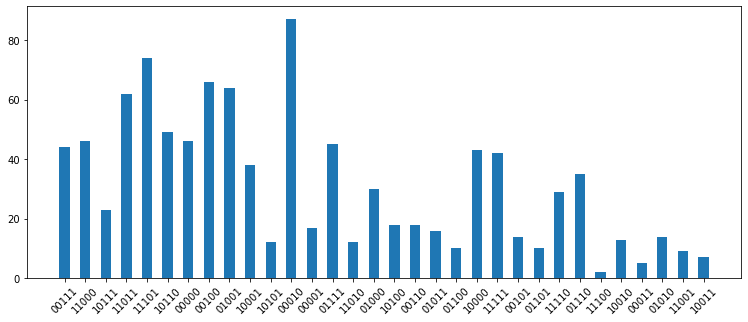

In [127]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut
plt.figure(figsize = (2**n_qubits/2.5,5))
plt.xticks(rotation=45)
plt.bar(occurrencies.keys(),occurrencies.values(),width = 0.5)

Plot function in parameaters space

### Extra 1. evalaute final state through projective measurment on computational basis

In [23]:
# initial state (as density matrix):
init_state = qaoa.initial_state(n_qubits)
#dm_init_state = qu.ket2dm(init_state)

In [78]:
# obtain final state:
optimal_params = optimal_params_scipy
#optimal_params = optimal_parameters_Adam_fin_diff
optimal_gammas = optimal_params[:n_levels]
optimal_betas = optimal_params[n_levels:]
fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*init_state
#dm_fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*dm_init_state*qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas).dag()

In [82]:
def comp_basis_prob_dist(qstate):
    prob_dist = []
    for component in qstate.full():
        prob_dist.append(float(abs(component))**2)
    return prob_dist

In [83]:
prob_dist_fin_state = comp_basis_prob_dist(fin_state)

<BarContainer object of 128 artists>

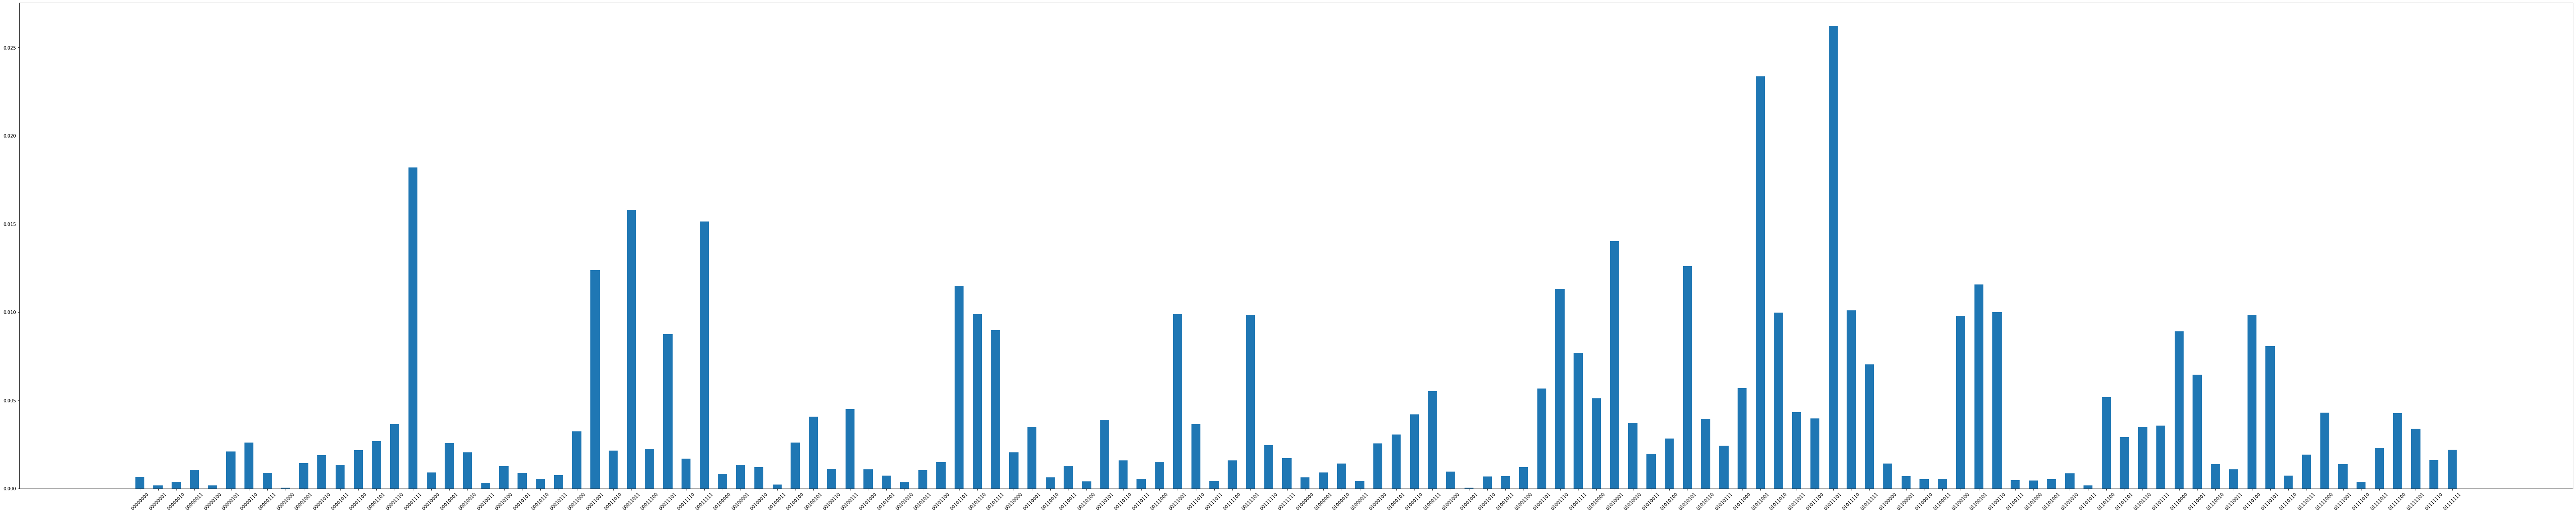

In [85]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut (using the state)
plt.figure(figsize = (2**n_qubits/2.5,20))
plt.xticks(rotation=45)
xticks = range(0,2**(n_qubits-1))
xtick_labels = list(map(lambda x: format(x, "0"+str(n_qubits)+'b'), xticks))
plt.bar(xtick_labels,prob_dist_fin_state[:2**(n_qubits-1)],width = 0.5)

Check solutions

In [86]:
dict_prob = {}
for i in range(int(len(prob_dist_fin_state)/2)):
    dict_prob[bin(i)[2:].zfill(n_qubits)] = prob_dist_fin_state[i]

In [87]:
maximum_cuts = find_maximum_cuts(n_qubits, edges)
maximum_cuts

['01011001', '01011101']

In [88]:
max_prob = sorted(list(dict_prob.values()))[-len(maximum_cuts):]

max_prob_states = []
for key in dict_prob.keys():
    for prob in max_prob:
        if dict_prob[key] == prob:
            max_prob_states.append(str(key))
            break

max_prob_states

['01011001', '01011101']

In [89]:
maximum_cuts == max_prob_states

True